In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="4"

Thu Jan 25 04:16:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [6]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.0
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings
hp.nonlinear = 0

In [7]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.755126953125
prior.nonlinear 0.628173828125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [8]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_nonlinear_nupdate/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [10]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [11]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [12]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

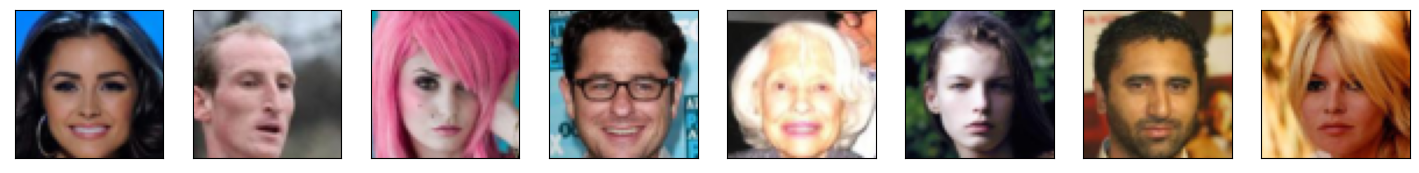

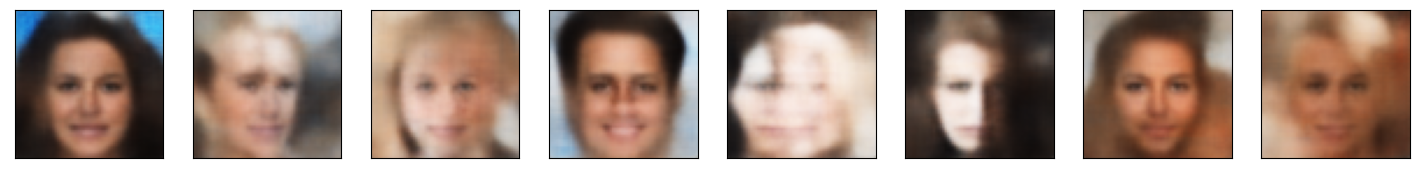

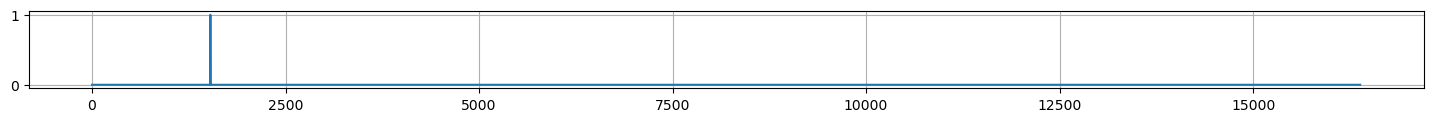

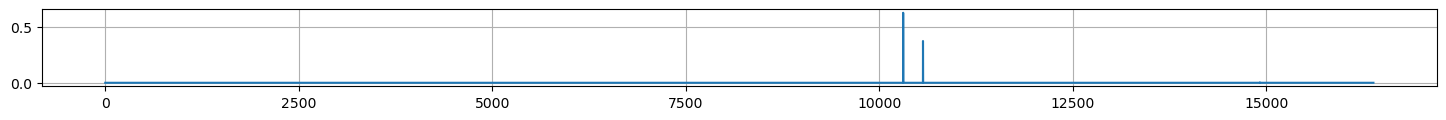

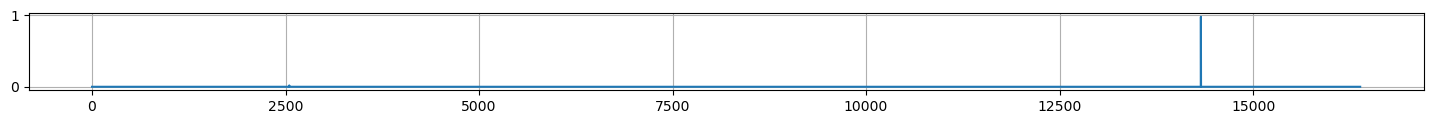

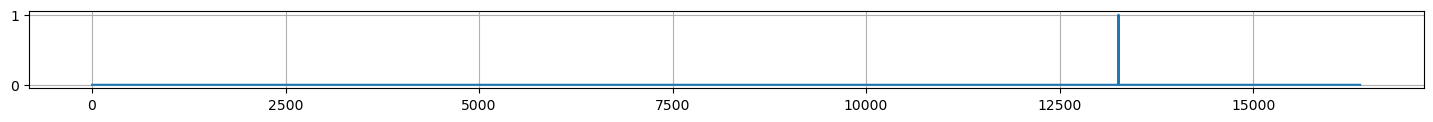

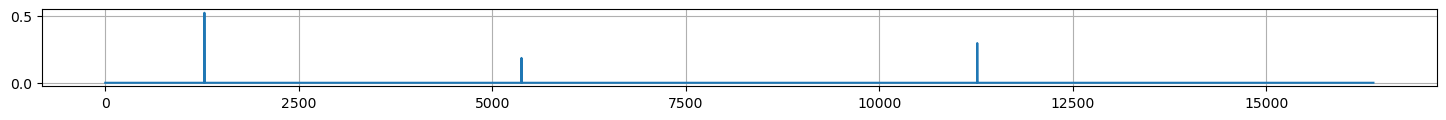

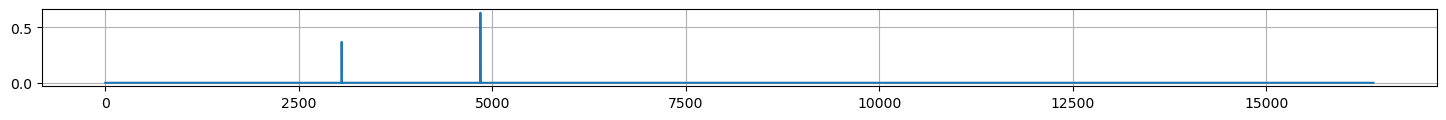

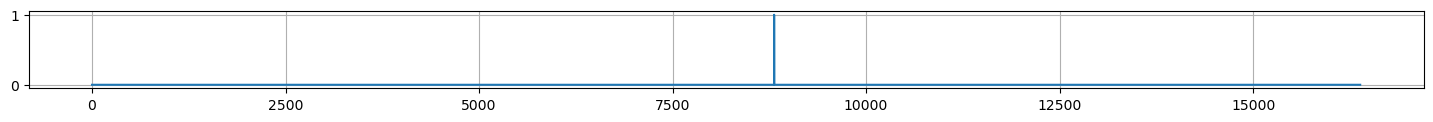

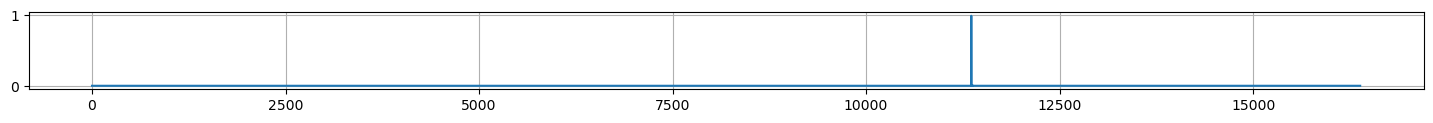

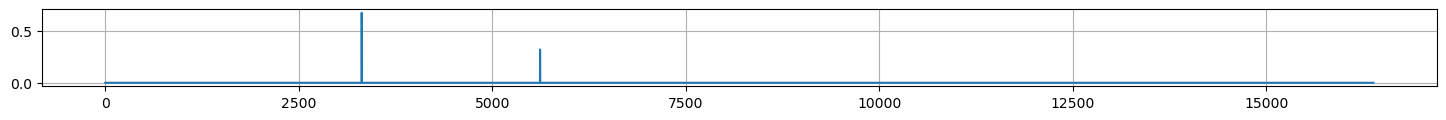

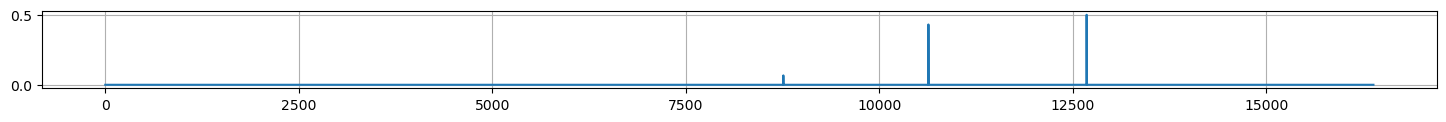

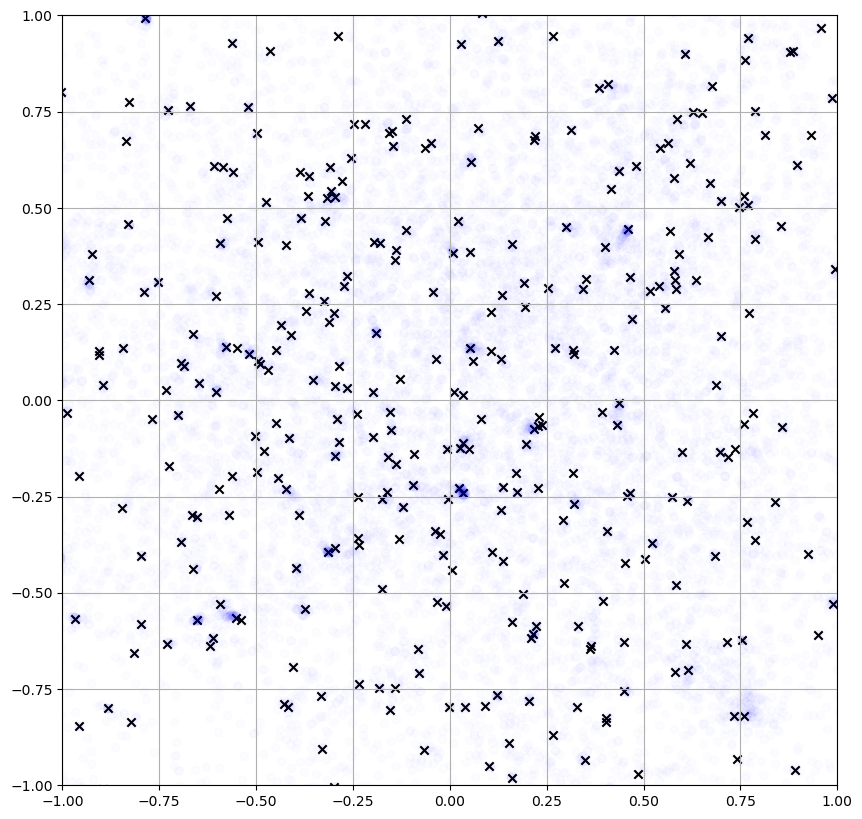

224001
lse_loss -357.3778076171875
commit_loss 0.103944793343544
recon_loss 0.01069854199886322
224002
lse_loss -348.6969299316406
commit_loss 0.10674185305833817
recon_loss 0.01085171289741993
224003
lse_loss -357.3310546875
commit_loss 0.10814403742551804
recon_loss 0.01136210560798645
224004
lse_loss -357.0951232910156
commit_loss 0.10514949262142181
recon_loss 0.011164911091327667
224005
lse_loss -357.45654296875
commit_loss 0.10744835436344147
recon_loss 0.01017235592007637
224006
lse_loss -359.7079162597656
commit_loss 0.1050395518541336
recon_loss 0.011260400526225567
224007
lse_loss -348.8943176269531
commit_loss 0.1073773205280304
recon_loss 0.010749507695436478
224008
lse_loss -359.3778076171875
commit_loss 0.10761147737503052
recon_loss 0.010293682105839252
224009
lse_loss -355.8036193847656
commit_loss 0.10786587744951248
recon_loss 0.011019358411431313
224010
lse_loss -352.7454833984375
commit_loss 0.10629139840602875
recon_loss 0.010867740027606487
224011
lse_loss -350.68

lse_loss -359.5819396972656
commit_loss 0.10248991847038269
recon_loss 0.010623982176184654
224087
lse_loss -358.8779296875
commit_loss 0.1050165593624115
recon_loss 0.010461374185979366
224088
lse_loss -360.56982421875
commit_loss 0.10597681254148483
recon_loss 0.00999477505683899
224089
lse_loss -362.7265930175781
commit_loss 0.10654686391353607
recon_loss 0.011101002804934978
224090
lse_loss -363.0362854003906
commit_loss 0.10679476708173752
recon_loss 0.010023319162428379
224091
lse_loss -352.4555358886719
commit_loss 0.10638764500617981
recon_loss 0.010343074798583984
224092
lse_loss -358.5729064941406
commit_loss 0.1065741628408432
recon_loss 0.010808700695633888
224093
lse_loss -358.955810546875
commit_loss 0.10588498413562775
recon_loss 0.010486598126590252
224094
lse_loss -364.0412292480469
commit_loss 0.10579489171504974
recon_loss 0.01052088849246502
224095
lse_loss -360.98443603515625
commit_loss 0.1083703488111496
recon_loss 0.011752630583941936
224096
lse_loss -363.269683

lse_loss -363.46453857421875
commit_loss 0.10113179683685303
recon_loss 0.010469223372638226
224172
lse_loss -362.018310546875
commit_loss 0.1052464097738266
recon_loss 0.009970949962735176
224173
lse_loss -362.06884765625
commit_loss 0.10696429014205933
recon_loss 0.010164417326450348
224174
lse_loss -359.5711975097656
commit_loss 0.1050209254026413
recon_loss 0.01093616709113121
224175
lse_loss -363.49169921875
commit_loss 0.10499115288257599
recon_loss 0.009880397468805313
224176
lse_loss -365.5810546875
commit_loss 0.10209738463163376
recon_loss 0.010956952348351479
224177
lse_loss -365.66766357421875
commit_loss 0.1033271849155426
recon_loss 0.011461402289569378
224178
lse_loss -356.8564758300781
commit_loss 0.10664206743240356
recon_loss 0.010600222274661064
224179
lse_loss -365.0564880371094
commit_loss 0.10470044612884521
recon_loss 0.0109963184222579
224180
lse_loss -364.7967834472656
commit_loss 0.10323818773031235
recon_loss 0.010531028732657433
224181
lse_loss -358.13784790

224256
lse_loss -364.582763671875
commit_loss 0.10412134975194931
recon_loss 0.010162172839045525
224257
lse_loss -360.4233703613281
commit_loss 0.10434545576572418
recon_loss 0.010065695270895958
224258
lse_loss -365.2259216308594
commit_loss 0.10330565273761749
recon_loss 0.01086029689759016
224259
lse_loss -365.331787109375
commit_loss 0.10538692772388458
recon_loss 0.010630406439304352
224260
lse_loss -364.5570373535156
commit_loss 0.1033216342329979
recon_loss 0.010746769607067108
224261
lse_loss -362.73248291015625
commit_loss 0.10016165673732758
recon_loss 0.010607723146677017
224262
lse_loss -353.8174743652344
commit_loss 0.10493475198745728
recon_loss 0.011122527532279491
224263
lse_loss -361.66357421875
commit_loss 0.10116475820541382
recon_loss 0.010303833521902561
224264
lse_loss -365.22662353515625
commit_loss 0.10138408094644547
recon_loss 0.009809676557779312
224265
lse_loss -363.8439025878906
commit_loss 0.10269708931446075
recon_loss 0.01057928055524826
224266
lse_loss

224341
lse_loss -360.42376708984375
commit_loss 0.10224378108978271
recon_loss 0.010350188240408897
224342
lse_loss -342.61004638671875
commit_loss 0.10364102572202682
recon_loss 0.010666919872164726
224343
lse_loss -363.6708984375
commit_loss 0.10155114531517029
recon_loss 0.01064596138894558
224344
lse_loss -359.4254150390625
commit_loss 0.1048479750752449
recon_loss 0.010898816399276257
224345
lse_loss -360.8265686035156
commit_loss 0.10799010097980499
recon_loss 0.011797292158007622
224346
lse_loss -359.84716796875
commit_loss 0.10211643576622009
recon_loss 0.01013357937335968
224347
lse_loss -362.20343017578125
commit_loss 0.10081654787063599
recon_loss 0.010850230231881142
224348
lse_loss -362.9599914550781
commit_loss 0.10027651488780975
recon_loss 0.010584509000182152
224349
lse_loss -362.7126159667969
commit_loss 0.10116967558860779
recon_loss 0.011696550995111465
224350
lse_loss -360.9992980957031
commit_loss 0.10585758835077286
recon_loss 0.009430504404008389
224351
lse_loss

224426
lse_loss -365.31146240234375
commit_loss 0.10291250795125961
recon_loss 0.010580766014754772
224427
lse_loss -365.6299743652344
commit_loss 0.10191646963357925
recon_loss 0.010837221518158913
224428
lse_loss -365.3056945800781
commit_loss 0.10174033045768738
recon_loss 0.01161292102187872
224429
lse_loss -364.2181701660156
commit_loss 0.10470855981111526
recon_loss 0.0094474907964468
224430
lse_loss -363.8104553222656
commit_loss 0.10377928614616394
recon_loss 0.010547514073550701
224431
lse_loss -365.96826171875
commit_loss 0.1018289178609848
recon_loss 0.009664775803685188
224432
lse_loss -358.9397888183594
commit_loss 0.10458144545555115
recon_loss 0.01058393158018589
224433
lse_loss -360.5040283203125
commit_loss 0.10461986809968948
recon_loss 0.010023481212556362
224434
lse_loss -365.7008056640625
commit_loss 0.103988878428936
recon_loss 0.01153190340846777
224435
lse_loss -362.43511962890625
commit_loss 0.10191825777292252
recon_loss 0.010201294906437397
224436
lse_loss -3

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.show() 